In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import fetch_lfw_people
from sklearn.neighbors import KNeighborsClassifier

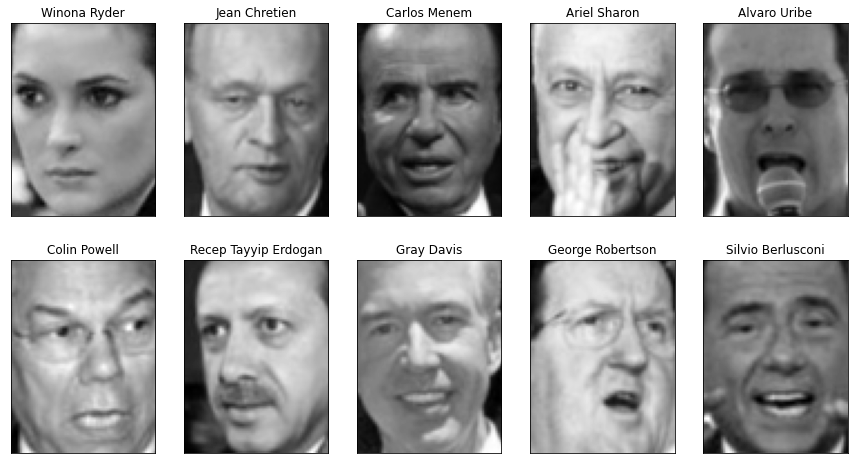

In [2]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])

In [3]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [4]:
counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [5]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]
X_people = X_people / 255

In [6]:
X_train, X_test, y_train, y_test = tts(
    X_people, y_people, stratify=y_people, random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


In [7]:
def distance(x_train, x_test):
    # find SS distance between all train and test points
    return ((x_train - x_test)**2).sum(axis=1)

def knn(x_train, x_test, y_train):
    # classify based on min distance (1-nn)
    return y_train[distance(x_train, x_test).argmin()]

def prediction(x_train, x_test, y_train):
    # return predicted classifications
    return [knn(x_train, test, y_train) for test in x_test]

y_pred = prediction(X_train, X_test, y_train)
print(sum([1 if pred == test else 0 for pred, test in zip(y_pred, y_test)])/y_test.shape[0])

0.23255813953488372


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0, ddof=1)
X_s_train = (X_train - mean)/std
X_s_test = (X_test - mean)/std
values, vectors = np.linalg.eig((X_s_train.T @ X_s_train)/(X_s_train.shape[0] - 1))

In [9]:
indices = values.argsort()[::-1][:100]
topValues = values[indices]
topVectors = vectors[:,indices]
projected_train = X_s_train @ topVectors
projected_test = X_s_test @ topVectors

y_pred = prediction(projected_train, projected_test, y_train)
print(sum([1 if pred == test else 0 for pred, test in zip(y_pred, y_test)])/y_test.shape[0])

0.25387596899224807


In [10]:
topValuesDiag = np.diag(np.power(topValues, -1/2))
whitened_train = topValuesDiag @ topVectors.T @ X_s_train.T
whitened_test = topValuesDiag @ topVectors.T @ X_s_test.T

y_pred = prediction(whitened_train.T, whitened_test.T, y_train)
print(sum([1 if pred == test else 0 for pred, test in zip(y_pred, y_test)])/y_test.shape[0])

0.3313953488372093


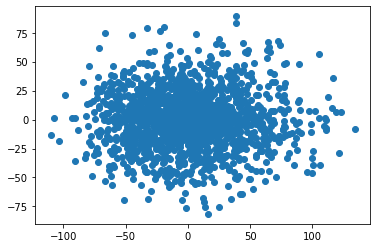

In [11]:
two = indices[:2]
twoValues = topValues[two]
twoVectors = topVectors[:,two]
projected_train = X_s_train @ twoVectors
projected_test = X_s_test @ twoVectors
plt.scatter(projected_train[:,0], projected_train[:,1])
plt.show()